In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

# Data

In [8]:
def forward(a, b, x):
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) / a.shape[1]

In [9]:
# Teacher Network
m = 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m)) - 0.5) # / m
b_star = 2 * np.random.uniform(size=(m, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m, INPUT_DIM))**2

In [10]:
# Data
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
y_val = forward(a_star, b_star, x_val)

# Algorithm iterations

In [11]:
def relu_prime(z):
    return (np.sign(z) + 1) / 2

In [12]:
def sample_neurons(n_samples=1):
    return np.random.normal(size=(n_samples, INPUT_DIM))

In [13]:
def forward_states(a, b, x):
    h_1 = np.matmul(x, b.T)
    x_1 = np.maximum(h_1, 0)
    y_hat = np.matmul(x_1, a.T) / a.shape[1]
    
    return h_1, x_1, y_hat

In [14]:
def initialize_neurons(x, y, n_neurons=1):
    # empty arrays and null prediction function
    a = np.array([[]])
    b = np.array([[]])
    y_hat = 0

    b_hat = sample_neurons(n_samples=n_neurons)
    x_1 = np.maximum(np.matmul(x, b_hat.T), 0)
    a_hat = - ALPHA * np.mean((y_hat - y) * x_1, axis=0)

    a = np.append(a, a_hat).reshape(1, n_neurons)
    b = np.append(b, b_hat).reshape(n_neurons, -1)

    return a, b

In [15]:
def update(a, b, x, y, n_updates=1, compute_loss=True):
    for _ in range(n_updates):
        h_1, x_1, y_hat = forward_states(a, b, x)
        delta = y_hat - y
        b = b - BASE_LR * np.matmul(np.matmul(relu_prime(h_1), np.diag(a.reshape(-1))).T,
                                    delta * x) / N_TRAIN
        a = a - BASE_LR * np.mean(delta * x_1, axis=0, keepdims=True)

    loss = -1.0
    if compute_loss:
        loss = 0.5 * np.mean(delta ** 2)

    return a, b, loss

In [16]:
def initialize_net(x, y, n_neurons=1):
    # initialize neurons  y sampling and setting weights accordingly
    a, b = initialize_neurons(x, y, n_neurons=n_neurons)

    # return as initialization for the network the first update for the sampled neurons / weights
    return update(a, b, x, y, n_updates=1)

In [17]:
def train(n_steps, a, b, x_train, y_train, x_val, y_val, do_val=True, n_samples=1, n_updates=1):
    train_losses = []
    val_losses = []
    neurons = [a.shape[1]]

    for i in tqdm(range(n_steps)):
        # sample neurons and set weights
        if n_samples > 0:
            if a.shape[1] <= N_MAX_NEURONS:
                b_hat = sample_neurons(n_samples=n_samples)
                x_1 = np.maximum(np.matmul(x_train, b_hat.T), 0)
                y_hat = forward(a, b, x_train)
                a_hat = - ALPHA * np.mean((y_hat - y_train) * x_1, axis=0, keepdims=True)

                # add newly sampled neurons / weights to the list
                a = np.hstack((a, a_hat))
                b = np.vstack((b, b_hat))
        
        neurons.append(a.shape[1])

        # update neurons / weights
        a, b, train_loss = update(a, b, x_train, y_train, n_updates=n_updates)
        train_losses.append(train_loss)

        # validation loop if do_val is True
        if do_val:
            if i % VAL_ITER == 0:
                y_hat = forward(a, b, x_val)
                val_loss = 0.5 * np.mean((y_hat - y_val) ** 2)
                val_losses.append(val_loss)
                print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))
                
    # final validation loop after training
    if do_val:
        y_hat = forward(a, b, x_val)
        val_loss = 0.5 * np.mean((y_hat - y_val) ** 2)
        val_losses.append(val_loss)
        print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
        print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))

    return a, b, np.array(train_losses), np.array(val_losses), np.array(neurons)

## 1. Standard Training with fixed \# neurons

In [18]:
# FULL LOOP (standard training with sampling only in the begining)
n_neurons = 1024

a, b, _ = initialize_net(x_train, y_train, n_neurons=n_neurons)
a, b, train_losses, val_losses, neurons = train(N_STEPS, a, b, x_train, y_train, x_val, y_val, n_samples=0)

  0%|                                          | 7/5000 [00:00<02:42, 30.70it/s]

Train loss at step 0 : 0.32553
Validation loss at step 0 : 0.26343


  2%|▊                                       | 109/5000 [00:02<01:55, 42.24it/s]

Train loss at step 100 : 0.20111
Validation loss at step 100 : 0.18368


  4%|█▋                                      | 209/5000 [00:04<01:37, 49.21it/s]

Train loss at step 200 : 0.12281
Validation loss at step 200 : 0.13955


  6%|██▍                                     | 306/5000 [00:07<01:37, 47.92it/s]

Train loss at step 300 : 0.07989
Validation loss at step 300 : 0.11980


  8%|███▎                                    | 410/5000 [00:09<01:29, 51.33it/s]

Train loss at step 400 : 0.05825
Validation loss at step 400 : 0.11385


 10%|████                                    | 501/5000 [00:12<02:26, 30.69it/s]

Train loss at step 500 : 0.04617
Validation loss at step 500 : 0.11311


 12%|████▊                                   | 604/5000 [00:15<02:19, 31.53it/s]

Train loss at step 600 : 0.03822
Validation loss at step 600 : 0.11375


 14%|█████▌                                  | 701/5000 [00:18<03:10, 22.53it/s]

Train loss at step 700 : 0.03229
Validation loss at step 700 : 0.11450


 16%|██████▍                                 | 802/5000 [00:25<04:58, 14.05it/s]

Train loss at step 800 : 0.02755
Validation loss at step 800 : 0.11511


 18%|███████▏                                | 906/5000 [00:29<01:28, 46.12it/s]

Train loss at step 900 : 0.02360
Validation loss at step 900 : 0.11552


 20%|███████▊                               | 1006/5000 [00:31<01:44, 38.34it/s]

Train loss at step 1,000 : 0.02025
Validation loss at step 1,000 : 0.11578


 22%|████████▌                              | 1103/5000 [00:34<03:36, 18.00it/s]

Train loss at step 1,100 : 0.01737
Validation loss at step 1,100 : 0.11594


 24%|█████████▍                             | 1210/5000 [00:38<01:31, 41.45it/s]

Train loss at step 1,200 : 0.01489
Validation loss at step 1,200 : 0.11602


 26%|██████████▏                            | 1307/5000 [00:40<01:24, 43.86it/s]

Train loss at step 1,300 : 0.01275
Validation loss at step 1,300 : 0.11604


 28%|██████████▉                            | 1405/5000 [00:42<01:19, 45.29it/s]

Train loss at step 1,400 : 0.01090
Validation loss at step 1,400 : 0.11601


 30%|███████████▊                           | 1509/5000 [00:44<01:05, 53.55it/s]

Train loss at step 1,500 : 0.00931
Validation loss at step 1,500 : 0.11595


 32%|████████████▌                          | 1611/5000 [00:46<01:02, 54.64it/s]

Train loss at step 1,600 : 0.00795
Validation loss at step 1,600 : 0.11589


 34%|█████████████▎                         | 1711/5000 [00:48<00:55, 58.74it/s]

Train loss at step 1,700 : 0.00678
Validation loss at step 1,700 : 0.11582


 36%|██████████████                         | 1805/5000 [00:50<01:26, 36.93it/s]

Train loss at step 1,800 : 0.00578
Validation loss at step 1,800 : 0.11575


 38%|██████████████▊                        | 1907/5000 [00:52<01:13, 42.11it/s]

Train loss at step 1,900 : 0.00493
Validation loss at step 1,900 : 0.11569


 40%|███████████████▋                       | 2006/5000 [00:55<01:12, 41.11it/s]

Train loss at step 2,000 : 0.00420
Validation loss at step 2,000 : 0.11564


 42%|████████████████▍                      | 2108/5000 [00:57<01:08, 42.18it/s]

Train loss at step 2,100 : 0.00358
Validation loss at step 2,100 : 0.11560


 44%|█████████████████▏                     | 2207/5000 [01:00<00:50, 54.81it/s]

Train loss at step 2,200 : 0.00305
Validation loss at step 2,200 : 0.11555


 46%|█████████████████▉                     | 2302/5000 [01:01<01:00, 44.31it/s]

Train loss at step 2,300 : 0.00260
Validation loss at step 2,300 : 0.11552


 48%|██████████████████▊                    | 2412/5000 [01:03<00:42, 60.85it/s]

Train loss at step 2,400 : 0.00222
Validation loss at step 2,400 : 0.11548


 50%|███████████████████▌                   | 2507/5000 [01:05<00:45, 54.97it/s]

Train loss at step 2,500 : 0.00190
Validation loss at step 2,500 : 0.11546


 52%|████████████████████▎                  | 2605/5000 [01:07<00:54, 43.85it/s]

Train loss at step 2,600 : 0.00163
Validation loss at step 2,600 : 0.11544


 54%|█████████████████████▏                 | 2710/5000 [01:09<00:38, 59.30it/s]

Train loss at step 2,700 : 0.00139
Validation loss at step 2,700 : 0.11542


 56%|█████████████████████▉                 | 2807/5000 [01:11<00:41, 52.73it/s]

Train loss at step 2,800 : 0.00120
Validation loss at step 2,800 : 0.11540


 58%|██████████████████████▋                | 2906/5000 [01:13<01:05, 32.07it/s]

Train loss at step 2,900 : 0.00103
Validation loss at step 2,900 : 0.11538


 60%|███████████████████████▍               | 3003/5000 [01:16<01:46, 18.81it/s]

Train loss at step 3,000 : 0.00088
Validation loss at step 3,000 : 0.11537


 62%|████████████████████████▏              | 3107/5000 [01:21<00:53, 35.15it/s]

Train loss at step 3,100 : 0.00076
Validation loss at step 3,100 : 0.11536


 64%|█████████████████████████              | 3209/5000 [01:23<00:37, 47.84it/s]

Train loss at step 3,200 : 0.00066
Validation loss at step 3,200 : 0.11536


 66%|█████████████████████████▊             | 3310/5000 [01:25<00:30, 56.16it/s]

Train loss at step 3,300 : 0.00057
Validation loss at step 3,300 : 0.11536


 68%|██████████████████████████▌            | 3405/5000 [01:28<00:35, 45.17it/s]

Train loss at step 3,400 : 0.00049
Validation loss at step 3,400 : 0.11536


 70%|███████████████████████████▎           | 3509/5000 [01:29<00:29, 51.25it/s]

Train loss at step 3,500 : 0.00043
Validation loss at step 3,500 : 0.11536


 72%|████████████████████████████▏          | 3607/5000 [01:32<00:29, 46.74it/s]

Train loss at step 3,600 : 0.00037
Validation loss at step 3,600 : 0.11536


 74%|████████████████████████████▉          | 3705/5000 [01:35<00:37, 34.59it/s]

Train loss at step 3,700 : 0.00032
Validation loss at step 3,700 : 0.11537


 76%|█████████████████████████████▋         | 3806/5000 [01:37<00:29, 40.57it/s]

Train loss at step 3,800 : 0.00028
Validation loss at step 3,800 : 0.11537


 78%|██████████████████████████████▍        | 3908/5000 [01:40<00:29, 37.50it/s]

Train loss at step 3,900 : 0.00024
Validation loss at step 3,900 : 0.11538


 80%|███████████████████████████████▎       | 4010/5000 [01:43<00:18, 52.78it/s]

Train loss at step 4,000 : 0.00021
Validation loss at step 4,000 : 0.11538


 82%|████████████████████████████████       | 4109/5000 [01:45<00:22, 40.46it/s]

Train loss at step 4,100 : 0.00018
Validation loss at step 4,100 : 0.11539


 84%|████████████████████████████████▊      | 4203/5000 [01:47<00:15, 52.76it/s]

Train loss at step 4,200 : 0.00016
Validation loss at step 4,200 : 0.11539


 86%|█████████████████████████████████▌     | 4303/5000 [01:50<00:23, 29.86it/s]

Train loss at step 4,300 : 0.00014
Validation loss at step 4,300 : 0.11540


 88%|██████████████████████████████████▎    | 4402/5000 [01:54<00:24, 24.81it/s]

Train loss at step 4,400 : 0.00012
Validation loss at step 4,400 : 0.11541


 90%|███████████████████████████████████▏   | 4505/5000 [01:58<00:17, 28.81it/s]

Train loss at step 4,500 : 0.00011
Validation loss at step 4,500 : 0.11541


 92%|███████████████████████████████████▉   | 4604/5000 [02:01<00:14, 27.65it/s]

Train loss at step 4,600 : 0.00010
Validation loss at step 4,600 : 0.11542


 94%|████████████████████████████████████▋  | 4706/5000 [02:05<00:09, 32.19it/s]

Train loss at step 4,700 : 0.00008
Validation loss at step 4,700 : 0.11543


 96%|█████████████████████████████████████▍ | 4806/5000 [02:08<00:05, 34.35it/s]

Train loss at step 4,800 : 0.00007
Validation loss at step 4,800 : 0.11544


 98%|██████████████████████████████████████▎| 4904/5000 [02:10<00:02, 34.49it/s]

Train loss at step 4,900 : 0.00006
Validation loss at step 4,900 : 0.11544


100%|███████████████████████████████████████| 5000/5000 [02:13<00:00, 37.33it/s]

Train loss at step 4,999 : 0.00006
Validation loss at step 4,999 : 0.11545


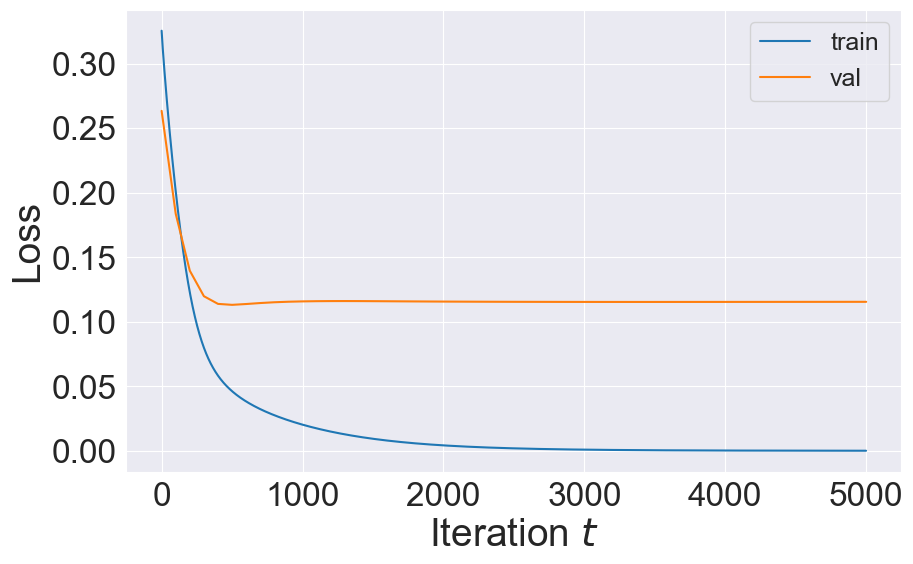

In [19]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val', 
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-std.png'), bbox_inches='tight')
plt.show()

## 2. Standard training with PyTorch (standard init)

In [20]:
# train data in PyTorch
x_train_pt = torch.from_numpy(x_train).float()
y_train_pt = torch.from_numpy(y_train).float()

# val data in PyTorch
x_val_pt = torch.from_numpy(x_val).float()
y_val_pt = torch.from_numpy(y_val).float()

In [21]:
# MF net with Gaussian init
m = 1024
bias = False
net = torch.nn.Sequential(*[torch.nn.Linear(in_features=INPUT_DIM, out_features=m, bias=bias),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=m, out_features=1, bias=bias)])

# init
with torch.no_grad():
    net[0].weight.data.copy_(torch.randn(size=(m, INPUT_DIM)))
    net[2].weight.data.copy_(torch.randn(size=(1, m)))
    
opt = torch.optim.SGD(params=net.parameters(), lr=m * BASE_LR)

In [22]:
do_val = True
train_losses = []
val_losses = []

for i in tqdm(range(N_STEPS)):
    opt.zero_grad()
    
    y_hat = net(x_train_pt) / m
    loss = 0.5 * torch.mean((y_train_pt - y_hat) ** 2)
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        train_loss = loss.detach().item()
        train_losses.append(train_loss)

    # validation loop if do_val is True
    if do_val:
        if i % VAL_ITER == 0:
            with torch.no_grad():
                y_hat = net(x_val_pt) / m
                val_loss = 0.5 * torch.mean((y_val_pt - y_hat) ** 2).detach().item()
                val_losses.append(val_loss)
                print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))
                
# final validation loop after training
if do_val:
    with torch.no_grad():
        y_hat = net(x_val_pt) / m
        val_loss = 0.5 * torch.mean((y_val_pt - y_hat) ** 2).detach().item()
        val_losses.append(val_loss)
        print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
        print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))

train_losses_pt = np.array(train_losses)
val_losses_pt = np.array(val_losses)

  1%|▎                                       | 46/5000 [00:00<00:22, 216.00it/s]

Train loss at step 0 : 0.49042
Validation loss at step 0 : 0.40454


  3%|▉                                      | 127/5000 [00:00<00:28, 172.05it/s]

Train loss at step 100 : 0.15955
Validation loss at step 100 : 0.17026


  5%|█▊                                     | 234/5000 [00:01<00:31, 153.64it/s]

Train loss at step 200 : 0.08345
Validation loss at step 200 : 0.12744


  6%|██▍                                    | 307/5000 [00:02<00:33, 139.72it/s]

Train loss at step 300 : 0.05406
Validation loss at step 300 : 0.11422


  8%|███▎                                   | 422/5000 [00:02<00:21, 211.68it/s]

Train loss at step 400 : 0.03989
Validation loss at step 400 : 0.11021


 11%|████▏                                  | 531/5000 [00:03<00:24, 182.24it/s]

Train loss at step 500 : 0.03116
Validation loss at step 500 : 0.10869


 13%|████▉                                  | 637/5000 [00:03<00:23, 188.84it/s]

Train loss at step 600 : 0.02492
Validation loss at step 600 : 0.10781


 15%|█████▋                                 | 732/5000 [00:04<00:18, 232.50it/s]

Train loss at step 700 : 0.02012
Validation loss at step 700 : 0.10716


 16%|██████▎                                | 813/5000 [00:05<00:29, 139.91it/s]

Train loss at step 800 : 0.01632
Validation loss at step 800 : 0.10660


 18%|███████▏                               | 923/5000 [00:05<00:24, 165.13it/s]

Train loss at step 900 : 0.01328
Validation loss at step 900 : 0.10613


 21%|███████▉                              | 1048/5000 [00:06<00:14, 273.57it/s]

Train loss at step 1,000 : 0.01082
Validation loss at step 1,000 : 0.10575


 23%|████████▊                             | 1160/5000 [00:06<00:11, 320.33it/s]

Train loss at step 1,100 : 0.00883
Validation loss at step 1,100 : 0.10542


 25%|█████████▌                            | 1259/5000 [00:06<00:12, 304.71it/s]

Train loss at step 1,200 : 0.00721
Validation loss at step 1,200 : 0.10515


 27%|██████████▍                           | 1366/5000 [00:06<00:10, 334.49it/s]

Train loss at step 1,300 : 0.00590
Validation loss at step 1,300 : 0.10490


 29%|██████████▉                           | 1435/5000 [00:07<00:10, 330.55it/s]

Train loss at step 1,400 : 0.00483
Validation loss at step 1,400 : 0.10468


 31%|███████████▋                          | 1535/5000 [00:07<00:10, 319.00it/s]

Train loss at step 1,500 : 0.00396
Validation loss at step 1,500 : 0.10449


 33%|████████████▍                         | 1631/5000 [00:07<00:13, 258.06it/s]

Train loss at step 1,600 : 0.00326
Validation loss at step 1,600 : 0.10432


 35%|█████████████▎                        | 1758/5000 [00:08<00:10, 295.11it/s]

Train loss at step 1,700 : 0.00268
Validation loss at step 1,700 : 0.10418


 37%|██████████████                        | 1853/5000 [00:08<00:10, 300.25it/s]

Train loss at step 1,800 : 0.00220
Validation loss at step 1,800 : 0.10406


 39%|██████████████▉                       | 1962/5000 [00:08<00:08, 342.32it/s]

Train loss at step 1,900 : 0.00182
Validation loss at step 1,900 : 0.10394


 41%|███████████████▊                      | 2073/5000 [00:09<00:08, 358.06it/s]

Train loss at step 2,000 : 0.00150
Validation loss at step 2,000 : 0.10385


 43%|████████████████▎                     | 2145/5000 [00:09<00:08, 352.97it/s]

Train loss at step 2,100 : 0.00125
Validation loss at step 2,100 : 0.10377


 45%|█████████████████▏                    | 2254/5000 [00:09<00:07, 356.69it/s]

Train loss at step 2,200 : 0.00103
Validation loss at step 2,200 : 0.10369


 47%|█████████████████▉                    | 2365/5000 [00:10<00:07, 363.75it/s]

Train loss at step 2,300 : 0.00086
Validation loss at step 2,300 : 0.10363


 49%|██████████████████▌                   | 2438/5000 [00:10<00:07, 342.13it/s]

Train loss at step 2,400 : 0.00071
Validation loss at step 2,400 : 0.10356


 51%|███████████████████▎                  | 2542/5000 [00:10<00:07, 339.28it/s]

Train loss at step 2,500 : 0.00060
Validation loss at step 2,500 : 0.10350


 53%|████████████████████▏                 | 2650/5000 [00:10<00:06, 352.23it/s]

Train loss at step 2,600 : 0.00050
Validation loss at step 2,600 : 0.10345


 55%|████████████████████▉                 | 2756/5000 [00:11<00:06, 323.28it/s]

Train loss at step 2,700 : 0.00042
Validation loss at step 2,700 : 0.10340


 57%|█████████████████████▊                | 2866/5000 [00:11<00:06, 348.13it/s]

Train loss at step 2,800 : 0.00035
Validation loss at step 2,800 : 0.10337


 59%|██████████████████████▎               | 2940/5000 [00:11<00:05, 353.95it/s]

Train loss at step 2,900 : 0.00029
Validation loss at step 2,900 : 0.10333


 61%|███████████████████████▏              | 3052/5000 [00:12<00:05, 360.50it/s]

Train loss at step 3,000 : 0.00025
Validation loss at step 3,000 : 0.10330


 63%|████████████████████████              | 3163/5000 [00:12<00:05, 354.70it/s]

Train loss at step 3,100 : 0.00021
Validation loss at step 3,100 : 0.10327


 65%|████████████████████████▌             | 3235/5000 [00:12<00:05, 341.03it/s]

Train loss at step 3,200 : 0.00017
Validation loss at step 3,200 : 0.10324


 67%|█████████████████████████▍            | 3346/5000 [00:12<00:04, 357.22it/s]

Train loss at step 3,300 : 0.00015
Validation loss at step 3,300 : 0.10322


 69%|██████████████████████████▎           | 3457/5000 [00:13<00:04, 363.39it/s]

Train loss at step 3,400 : 0.00012
Validation loss at step 3,400 : 0.10319


 71%|██████████████████████████▊           | 3531/5000 [00:13<00:04, 336.73it/s]

Train loss at step 3,500 : 0.00010
Validation loss at step 3,500 : 0.10318


 73%|███████████████████████████▌          | 3632/5000 [00:13<00:04, 291.17it/s]

Train loss at step 3,600 : 0.00009
Validation loss at step 3,600 : 0.10316


 74%|████████████████████████████▏         | 3714/5000 [00:14<00:06, 202.51it/s]

Train loss at step 3,700 : 0.00008
Validation loss at step 3,700 : 0.10314


 76%|█████████████████████████████         | 3821/5000 [00:15<00:09, 125.14it/s]

Train loss at step 3,800 : 0.00006
Validation loss at step 3,800 : 0.10313


 79%|█████████████████████████████▉        | 3937/5000 [00:16<00:06, 153.70it/s]

Train loss at step 3,900 : 0.00005
Validation loss at step 3,900 : 0.10312


 81%|██████████████████████████████▊       | 4050/5000 [00:16<00:03, 247.99it/s]

Train loss at step 4,000 : 0.00005
Validation loss at step 4,000 : 0.10310


 84%|███████████████████████████████▋      | 4175/5000 [00:17<00:02, 354.94it/s]

Train loss at step 4,100 : 0.00004
Validation loss at step 4,100 : 0.10309


 85%|████████████████████████████████▎     | 4259/5000 [00:17<00:01, 385.77it/s]

Train loss at step 4,200 : 0.00003
Validation loss at step 4,200 : 0.10308


 87%|████████████████████████████████▉     | 4338/5000 [00:17<00:01, 388.20it/s]

Train loss at step 4,300 : 0.00003
Validation loss at step 4,300 : 0.10307


 89%|█████████████████████████████████▋    | 4440/5000 [00:18<00:02, 241.07it/s]

Train loss at step 4,400 : 0.00002
Validation loss at step 4,400 : 0.10306


 91%|██████████████████████████████████▌   | 4550/5000 [00:18<00:01, 297.04it/s]

Train loss at step 4,500 : 0.00002
Validation loss at step 4,500 : 0.10305


 93%|███████████████████████████████████▎  | 4645/5000 [00:18<00:01, 289.71it/s]

Train loss at step 4,600 : 0.00002
Validation loss at step 4,600 : 0.10305


 95%|████████████████████████████████████  | 4744/5000 [00:19<00:00, 310.93it/s]

Train loss at step 4,700 : 0.00002
Validation loss at step 4,700 : 0.10304


 97%|████████████████████████████████████▉ | 4859/5000 [00:19<00:00, 355.13it/s]

Train loss at step 4,800 : 0.00001
Validation loss at step 4,800 : 0.10303


100%|█████████████████████████████████████▊| 4979/5000 [00:19<00:00, 383.59it/s]

Train loss at step 4,900 : 0.00001
Validation loss at step 4,900 : 0.10303


100%|██████████████████████████████████████| 5000/5000 [00:19<00:00, 253.38it/s]

Train loss at step 4,999 : 0.00001
Validation loss at step 4,999 : 0.10302


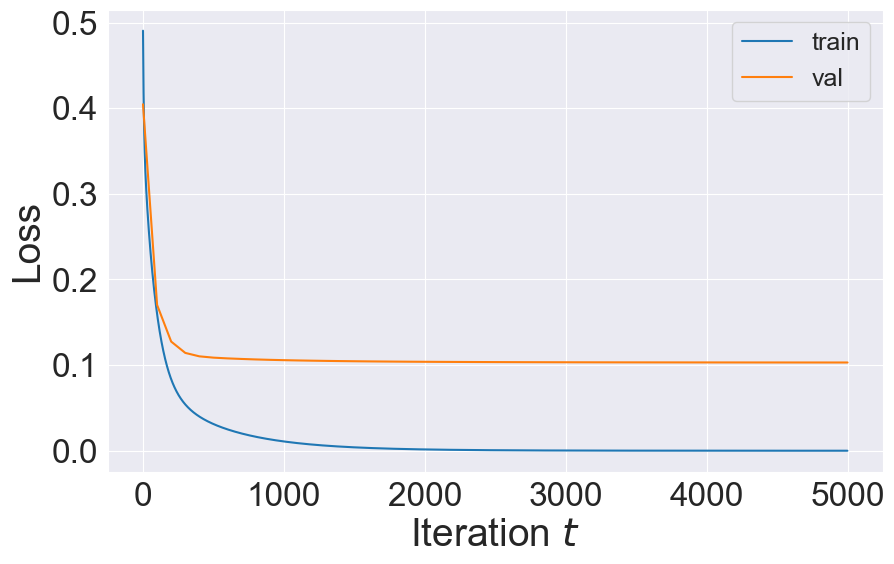

In [23]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')


plt.plot(np.arange(len(train_losses_pt)), train_losses_pt, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses_pt))], val_losses_pt, label='val', 
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'losses-pt.png'), bbox_inches='tight')
plt.show()

## 3. Pop-conic algorithm

In [24]:
# FULL LOOP (POP-CONIC 1 sample & 1 update per step)
n_neurons = 1
n_updates = 1

a, b, _ = initialize_net(x_train, y_train, n_neurons=n_neurons)
a, b, train_losses, val_losses, neurons = train(N_STEPS, a, b, x_train, y_train, x_val, y_val, 
                                                n_samples=n_neurons, n_updates=n_updates)

  2%|▊                                     | 104/5000 [00:00<00:04, 1035.84it/s]

Train loss at step 0 : 0.35991
Validation loss at step 0 : 0.31944
Train loss at step 100 : 0.27280
Validation loss at step 100 : 0.24030


  4%|█▌                                     | 208/5000 [00:00<00:06, 699.58it/s]

Train loss at step 200 : 0.21646
Validation loss at step 200 : 0.20738


  6%|██▏                                    | 285/5000 [00:00<00:10, 455.62it/s]

Train loss at step 300 : 0.16525
Validation loss at step 300 : 0.17405


  8%|███▏                                   | 407/5000 [00:01<00:35, 128.68it/s]

Train loss at step 400 : 0.12469
Validation loss at step 400 : 0.14743


 10%|███▉                                   | 511/5000 [00:02<00:39, 113.68it/s]

Train loss at step 500 : 0.09601
Validation loss at step 500 : 0.12837


 12%|████▊                                   | 600/5000 [00:03<00:59, 74.33it/s]

Train loss at step 600 : 0.07658
Validation loss at step 600 : 0.11605


 14%|█████▋                                  | 714/5000 [00:05<00:58, 73.74it/s]

Train loss at step 700 : 0.06327
Validation loss at step 700 : 0.10922


 16%|██████▍                                 | 811/5000 [00:07<01:13, 57.12it/s]

Train loss at step 800 : 0.05395
Validation loss at step 800 : 0.10531


 18%|███████▎                                | 910/5000 [00:09<01:32, 44.06it/s]

Train loss at step 900 : 0.04691
Validation loss at step 900 : 0.10282


 20%|███████▊                               | 1008/5000 [00:11<01:47, 37.15it/s]

Train loss at step 1,000 : 0.04129
Validation loss at step 1,000 : 0.10112


 22%|████████▌                              | 1099/5000 [00:14<01:57, 33.07it/s]

Train loss at step 1,100 : 0.03666
Validation loss at step 1,100 : 0.09994


 24%|█████████▍                             | 1206/5000 [00:18<02:09, 29.26it/s]

Train loss at step 1,200 : 0.03282
Validation loss at step 1,200 : 0.09913


 26%|██████████▏                            | 1303/5000 [00:21<03:44, 16.48it/s]

Train loss at step 1,300 : 0.02953
Validation loss at step 1,300 : 0.09860


 28%|██████████▉                            | 1404/5000 [00:28<02:50, 21.08it/s]

Train loss at step 1,400 : 0.02668
Validation loss at step 1,400 : 0.09814


 30%|███████████▋                           | 1502/5000 [00:33<04:24, 13.20it/s]

Train loss at step 1,500 : 0.02419
Validation loss at step 1,500 : 0.09768


 32%|████████████▌                          | 1603/5000 [00:40<04:16, 13.25it/s]

Train loss at step 1,600 : 0.02199
Validation loss at step 1,600 : 0.09730


 34%|█████████████▎                         | 1704/5000 [00:49<03:38, 15.08it/s]

Train loss at step 1,700 : 0.02004
Validation loss at step 1,700 : 0.09695


 36%|██████████████                         | 1802/5000 [00:56<04:40, 11.38it/s]

Train loss at step 1,800 : 0.01829
Validation loss at step 1,800 : 0.09659


 38%|██████████████▊                        | 1902/5000 [01:05<06:22,  8.10it/s]

Train loss at step 1,900 : 0.01672
Validation loss at step 1,900 : 0.09628


 40%|███████████████▌                       | 2003/5000 [01:18<04:49, 10.37it/s]

Train loss at step 2,000 : 0.01530
Validation loss at step 2,000 : 0.09604


 42%|████████████████▍                      | 2102/5000 [01:27<03:38, 13.26it/s]

Train loss at step 2,100 : 0.01231
Validation loss at step 2,100 : 0.09695


 44%|█████████████████▏                     | 2203/5000 [01:36<03:30, 13.29it/s]

Train loss at step 2,200 : 0.01026
Validation loss at step 2,200 : 0.09747


 46%|█████████████████▉                     | 2302/5000 [01:44<03:10, 14.18it/s]

Train loss at step 2,300 : 0.00864
Validation loss at step 2,300 : 0.09770


 48%|██████████████████▋                    | 2403/5000 [01:51<02:36, 16.59it/s]

Train loss at step 2,400 : 0.00729
Validation loss at step 2,400 : 0.09778


 50%|███████████████████▌                   | 2501/5000 [02:01<05:27,  7.63it/s]

Train loss at step 2,500 : 0.00616
Validation loss at step 2,500 : 0.09781


 52%|████████████████████▎                  | 2602/5000 [02:14<04:30,  8.85it/s]

Train loss at step 2,600 : 0.00522
Validation loss at step 2,600 : 0.09781


 54%|█████████████████████                  | 2702/5000 [02:26<04:58,  7.71it/s]

Train loss at step 2,700 : 0.00442
Validation loss at step 2,700 : 0.09779


 56%|█████████████████████▊                 | 2802/5000 [02:37<03:26, 10.63it/s]

Train loss at step 2,800 : 0.00375
Validation loss at step 2,800 : 0.09778


 58%|██████████████████████▋                | 2902/5000 [02:44<02:08, 16.35it/s]

Train loss at step 2,900 : 0.00319
Validation loss at step 2,900 : 0.09777


 60%|███████████████████████▍               | 3004/5000 [02:50<02:05, 15.85it/s]

Train loss at step 3,000 : 0.00271
Validation loss at step 3,000 : 0.09776


 62%|████████████████████████▏              | 3102/5000 [02:56<02:05, 15.15it/s]

Train loss at step 3,100 : 0.00231
Validation loss at step 3,100 : 0.09777


 64%|████████████████████████▉              | 3204/5000 [03:07<02:08, 13.94it/s]

Train loss at step 3,200 : 0.00198
Validation loss at step 3,200 : 0.09777


 66%|█████████████████████████▊             | 3302/5000 [03:15<02:16, 12.46it/s]

Train loss at step 3,300 : 0.00169
Validation loss at step 3,300 : 0.09776


 68%|██████████████████████████▌            | 3402/5000 [03:24<02:04, 12.81it/s]

Train loss at step 3,400 : 0.00145
Validation loss at step 3,400 : 0.09777


 70%|███████████████████████████▎           | 3504/5000 [03:31<01:20, 18.70it/s]

Train loss at step 3,500 : 0.00124
Validation loss at step 3,500 : 0.09777


 72%|████████████████████████████           | 3604/5000 [03:39<01:35, 14.59it/s]

Train loss at step 3,600 : 0.00107
Validation loss at step 3,600 : 0.09779


 74%|████████████████████████████▉          | 3704/5000 [03:47<01:13, 17.72it/s]

Train loss at step 3,700 : 0.00092
Validation loss at step 3,700 : 0.09780


 76%|█████████████████████████████▋         | 3802/5000 [04:00<03:15,  6.11it/s]

Train loss at step 3,800 : 0.00079
Validation loss at step 3,800 : 0.09782


 78%|██████████████████████████████▍        | 3902/5000 [04:14<02:41,  6.80it/s]

Train loss at step 3,900 : 0.00069
Validation loss at step 3,900 : 0.09783


 80%|███████████████████████████████▏       | 4002/5000 [04:29<02:16,  7.33it/s]

Train loss at step 4,000 : 0.00059
Validation loss at step 4,000 : 0.09783


 82%|███████████████████████████████▉       | 4102/5000 [04:43<02:19,  6.43it/s]

Train loss at step 4,100 : 0.00051
Validation loss at step 4,100 : 0.09784


 84%|████████████████████████████████▊      | 4202/5000 [04:58<01:59,  6.68it/s]

Train loss at step 4,200 : 0.00045
Validation loss at step 4,200 : 0.09785


 86%|█████████████████████████████████▌     | 4302/5000 [05:12<01:43,  6.76it/s]

Train loss at step 4,300 : 0.00039
Validation loss at step 4,300 : 0.09786


 88%|██████████████████████████████████▎    | 4402/5000 [05:26<01:23,  7.18it/s]

Train loss at step 4,400 : 0.00034
Validation loss at step 4,400 : 0.09787


 90%|███████████████████████████████████    | 4502/5000 [05:40<01:12,  6.91it/s]

Train loss at step 4,500 : 0.00029
Validation loss at step 4,500 : 0.09788


 92%|███████████████████████████████████▉   | 4602/5000 [05:54<00:55,  7.14it/s]

Train loss at step 4,600 : 0.00026
Validation loss at step 4,600 : 0.09789


 94%|████████████████████████████████████▋  | 4702/5000 [06:06<00:34,  8.56it/s]

Train loss at step 4,700 : 0.00022
Validation loss at step 4,700 : 0.09790


 96%|█████████████████████████████████████▍ | 4802/5000 [06:18<00:22,  8.62it/s]

Train loss at step 4,800 : 0.00020
Validation loss at step 4,800 : 0.09791


 98%|██████████████████████████████████████▏| 4902/5000 [06:29<00:10,  9.14it/s]

Train loss at step 4,900 : 0.00017
Validation loss at step 4,900 : 0.09792


100%|███████████████████████████████████████| 5000/5000 [06:39<00:00, 12.51it/s]


Train loss at step 4,999 : 0.00015
Validation loss at step 4,999 : 0.09792


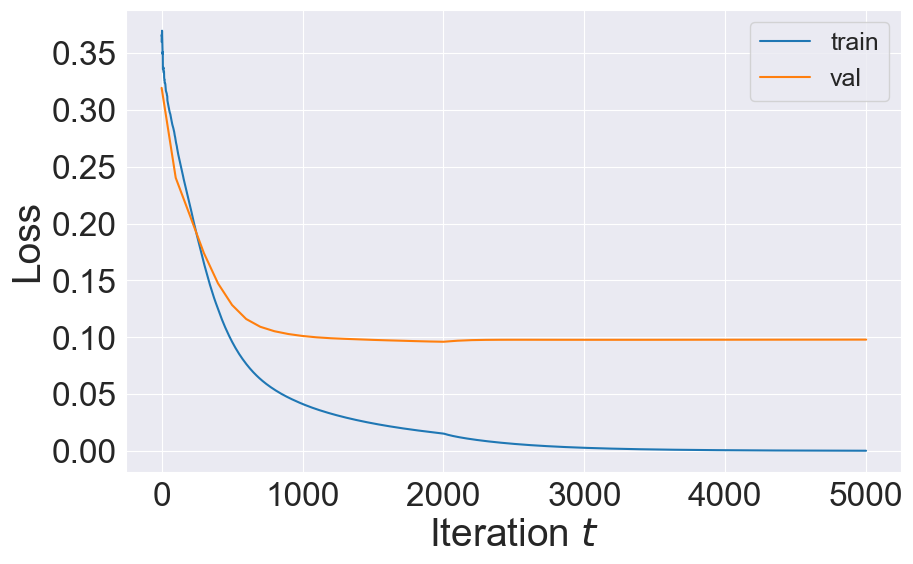

In [25]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'losses-basic.png'), bbox_inches='tight')
plt.show()

In [26]:
len(neurons)

5001

In [27]:
len(train_losses)

5000

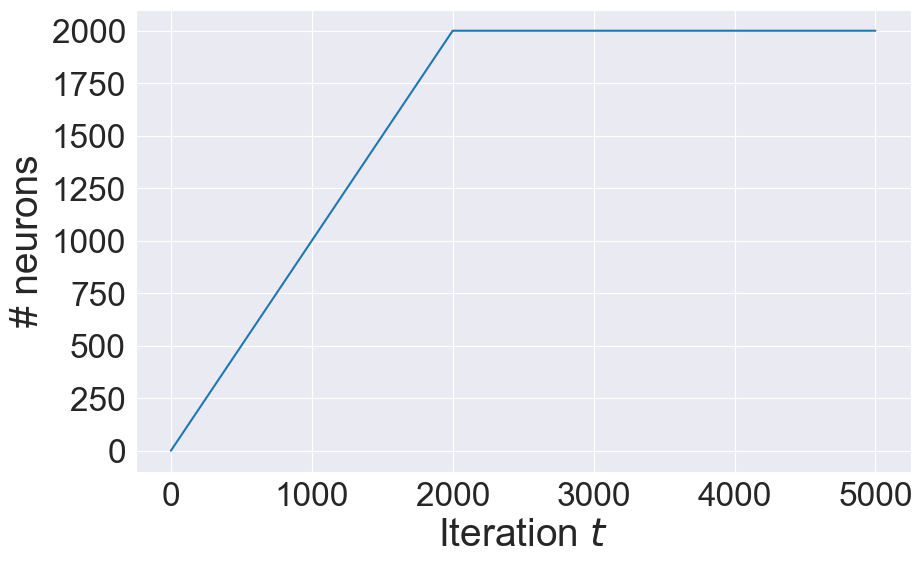

In [28]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(neurons)), neurons)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('# neurons', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'neurons-1-1.png'), bbox_inches='tight')
plt.show()

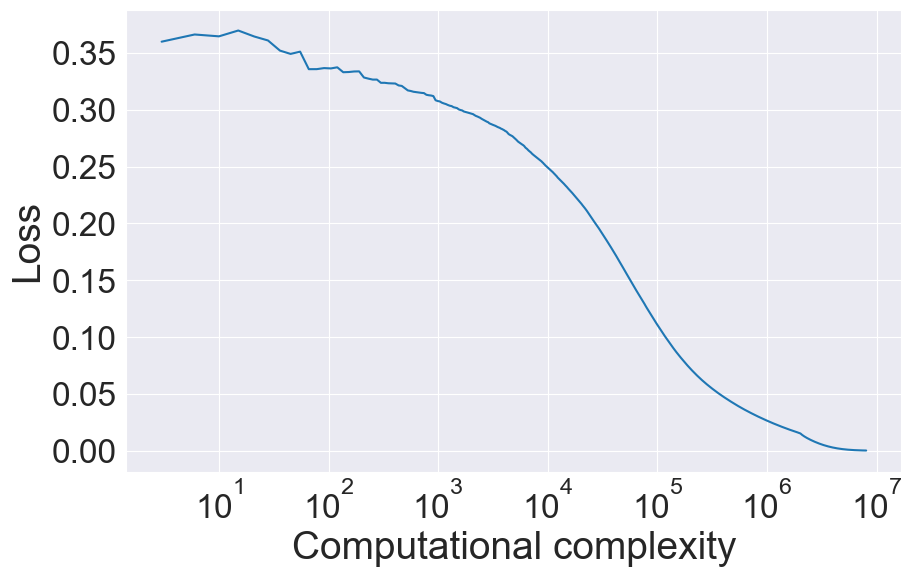

In [29]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses)

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-1-1.png'), bbox_inches='tight')
plt.show()

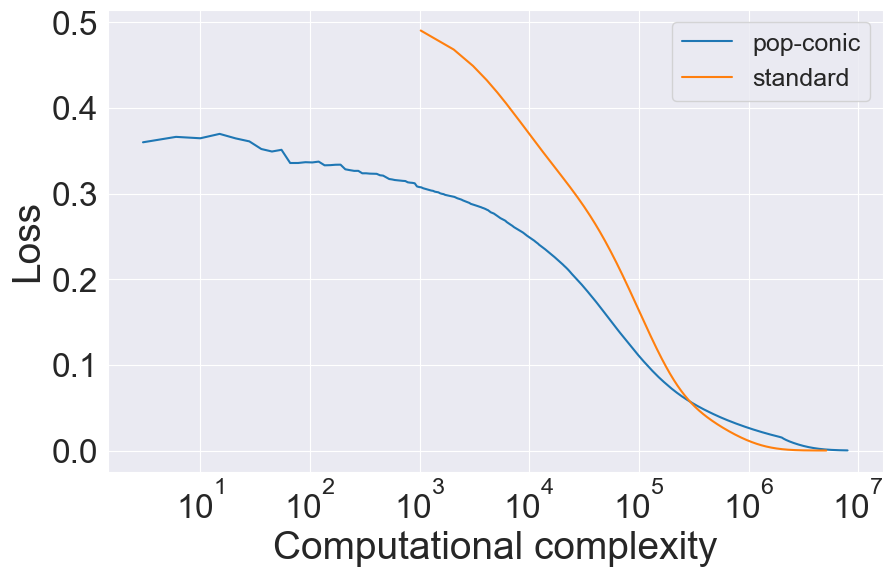

In [30]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses, label='pop-conic')
plt.plot([m*(k+1) for k in range(len(train_losses_pt))], train_losses_pt, label='standard')

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity.png'), bbox_inches='tight')
plt.show()

In [31]:
# FULL LOOP (POP-CONIC 10 samples & 1 update per step)
n_neurons = 10
n_updates = 1

a, b, _ = initialize_net(x_train, y_train, n_neurons=n_neurons)
a, b, train_losses, val_losses, neurons = train(N_STEPS, a, b, x_train, y_train, x_val, y_val, 
                                       n_samples=n_neurons, n_updates=n_updates)

  1%|▏                                       | 31/5000 [00:00<00:16, 292.83it/s]

Train loss at step 0 : 0.35648
Validation loss at step 0 : 0.26993


  2%|▊                                       | 105/5000 [00:01<02:18, 35.40it/s]

Train loss at step 100 : 0.26234
Validation loss at step 100 : 0.22462


  4%|█▌                                      | 203/5000 [00:08<06:22, 12.54it/s]

Train loss at step 200 : 0.20569
Validation loss at step 200 : 0.19027


  6%|██▍                                     | 303/5000 [00:14<06:31, 12.00it/s]

Train loss at step 300 : 0.12480
Validation loss at step 300 : 0.14268


  8%|███▏                                    | 403/5000 [00:21<05:08, 14.91it/s]

Train loss at step 400 : 0.08038
Validation loss at step 400 : 0.12010


 10%|████                                    | 503/5000 [00:29<07:00, 10.70it/s]

Train loss at step 500 : 0.05806
Validation loss at step 500 : 0.11218


 12%|████▊                                   | 603/5000 [00:37<04:12, 17.41it/s]

Train loss at step 600 : 0.04572
Validation loss at step 600 : 0.11020


 14%|█████▌                                  | 703/5000 [00:43<04:57, 14.44it/s]

Train loss at step 700 : 0.03763
Validation loss at step 700 : 0.10995


 16%|██████▍                                 | 803/5000 [00:50<03:58, 17.60it/s]

Train loss at step 800 : 0.03158
Validation loss at step 800 : 0.11003


 18%|███████▏                                | 903/5000 [00:56<03:47, 18.02it/s]

Train loss at step 900 : 0.02674
Validation loss at step 900 : 0.11005


 20%|███████▊                               | 1003/5000 [01:01<03:33, 18.74it/s]

Train loss at step 1,000 : 0.02271
Validation loss at step 1,000 : 0.10998


 22%|████████▌                              | 1103/5000 [01:07<04:07, 15.72it/s]

Train loss at step 1,100 : 0.01931
Validation loss at step 1,100 : 0.10983


 24%|█████████▍                             | 1203/5000 [01:14<03:34, 17.67it/s]

Train loss at step 1,200 : 0.01641
Validation loss at step 1,200 : 0.10965


 26%|██████████▏                            | 1303/5000 [01:20<03:18, 18.63it/s]

Train loss at step 1,300 : 0.01393
Validation loss at step 1,300 : 0.10943


 28%|██████████▉                            | 1403/5000 [01:25<03:10, 18.91it/s]

Train loss at step 1,400 : 0.01182
Validation loss at step 1,400 : 0.10921


 30%|███████████▋                           | 1503/5000 [01:31<03:08, 18.60it/s]

Train loss at step 1,500 : 0.01002
Validation loss at step 1,500 : 0.10899


 32%|████████████▌                          | 1603/5000 [01:36<03:01, 18.74it/s]

Train loss at step 1,600 : 0.00849
Validation loss at step 1,600 : 0.10880


 34%|█████████████▎                         | 1703/5000 [01:42<03:16, 16.80it/s]

Train loss at step 1,700 : 0.00719
Validation loss at step 1,700 : 0.10862


 36%|██████████████                         | 1803/5000 [01:49<02:55, 18.18it/s]

Train loss at step 1,800 : 0.00609
Validation loss at step 1,800 : 0.10846


 38%|██████████████▊                        | 1902/5000 [01:58<05:28,  9.42it/s]

Train loss at step 1,900 : 0.00515
Validation loss at step 1,900 : 0.10833


 40%|███████████████▌                       | 2002/5000 [02:07<07:00,  7.13it/s]

Train loss at step 2,000 : 0.00437
Validation loss at step 2,000 : 0.10821


 42%|████████████████▍                      | 2102/5000 [02:16<04:23, 11.02it/s]

Train loss at step 2,100 : 0.00370
Validation loss at step 2,100 : 0.10810


 44%|█████████████████▏                     | 2204/5000 [02:23<02:47, 16.72it/s]

Train loss at step 2,200 : 0.00314
Validation loss at step 2,200 : 0.10800


 46%|█████████████████▉                     | 2304/5000 [02:30<02:38, 17.05it/s]

Train loss at step 2,300 : 0.00266
Validation loss at step 2,300 : 0.10791


 48%|██████████████████▋                    | 2402/5000 [02:37<03:29, 12.39it/s]

Train loss at step 2,400 : 0.00226
Validation loss at step 2,400 : 0.10783


 50%|███████████████████▌                   | 2504/5000 [02:44<02:43, 15.22it/s]

Train loss at step 2,500 : 0.00192
Validation loss at step 2,500 : 0.10776


 52%|████████████████████▎                  | 2602/5000 [02:50<02:29, 16.01it/s]

Train loss at step 2,600 : 0.00164
Validation loss at step 2,600 : 0.10771


 54%|█████████████████████                  | 2704/5000 [02:56<02:01, 18.92it/s]

Train loss at step 2,700 : 0.00140
Validation loss at step 2,700 : 0.10767


 56%|█████████████████████▊                 | 2804/5000 [03:01<01:55, 18.97it/s]

Train loss at step 2,800 : 0.00119
Validation loss at step 2,800 : 0.10763


 58%|██████████████████████▋                | 2904/5000 [03:07<01:50, 19.01it/s]

Train loss at step 2,900 : 0.00102
Validation loss at step 2,900 : 0.10760


 60%|███████████████████████▍               | 3004/5000 [03:13<01:49, 18.26it/s]

Train loss at step 3,000 : 0.00087
Validation loss at step 3,000 : 0.10757


 62%|████████████████████████▏              | 3104/5000 [03:18<01:41, 18.63it/s]

Train loss at step 3,100 : 0.00075
Validation loss at step 3,100 : 0.10754


 64%|████████████████████████▉              | 3200/5000 [03:24<02:03, 14.58it/s]

Train loss at step 3,200 : 0.00064
Validation loss at step 3,200 : 0.10752


 66%|█████████████████████████▊             | 3302/5000 [03:30<01:43, 16.48it/s]

Train loss at step 3,300 : 0.00055
Validation loss at step 3,300 : 0.10750


 68%|██████████████████████████▌            | 3404/5000 [03:38<01:32, 17.25it/s]

Train loss at step 3,400 : 0.00048
Validation loss at step 3,400 : 0.10748


 70%|███████████████████████████▎           | 3504/5000 [03:44<01:30, 16.62it/s]

Train loss at step 3,500 : 0.00041
Validation loss at step 3,500 : 0.10747


 72%|████████████████████████████           | 3604/5000 [03:50<01:26, 16.17it/s]

Train loss at step 3,600 : 0.00035
Validation loss at step 3,600 : 0.10745


 74%|████████████████████████████▉          | 3704/5000 [03:56<01:23, 15.55it/s]

Train loss at step 3,700 : 0.00031
Validation loss at step 3,700 : 0.10744


 76%|█████████████████████████████▋         | 3802/5000 [04:05<03:28,  5.73it/s]

Train loss at step 3,800 : 0.00027
Validation loss at step 3,800 : 0.10743


 78%|██████████████████████████████▍        | 3903/5000 [04:14<01:08, 15.94it/s]

Train loss at step 3,900 : 0.00023
Validation loss at step 3,900 : 0.10742


 80%|███████████████████████████████▏       | 4003/5000 [04:20<01:02, 15.84it/s]

Train loss at step 4,000 : 0.00020
Validation loss at step 4,000 : 0.10741


 82%|████████████████████████████████       | 4103/5000 [04:27<01:17, 11.57it/s]

Train loss at step 4,100 : 0.00017
Validation loss at step 4,100 : 0.10740


 84%|████████████████████████████████▊      | 4203/5000 [04:34<00:55, 14.45it/s]

Train loss at step 4,200 : 0.00015
Validation loss at step 4,200 : 0.10739


 86%|█████████████████████████████████▌     | 4303/5000 [04:41<00:47, 14.52it/s]

Train loss at step 4,300 : 0.00013
Validation loss at step 4,300 : 0.10738


 88%|██████████████████████████████████▎    | 4403/5000 [04:47<00:38, 15.67it/s]

Train loss at step 4,400 : 0.00011
Validation loss at step 4,400 : 0.10737


 90%|███████████████████████████████████    | 4503/5000 [04:54<00:27, 18.25it/s]

Train loss at step 4,500 : 0.00010
Validation loss at step 4,500 : 0.10736


 92%|███████████████████████████████████▉   | 4603/5000 [05:00<00:21, 18.53it/s]

Train loss at step 4,600 : 0.00009
Validation loss at step 4,600 : 0.10736


 94%|████████████████████████████████████▋  | 4704/5000 [05:07<00:17, 16.76it/s]

Train loss at step 4,700 : 0.00008
Validation loss at step 4,700 : 0.10735


 96%|█████████████████████████████████████▍ | 4804/5000 [05:14<00:13, 14.79it/s]

Train loss at step 4,800 : 0.00007
Validation loss at step 4,800 : 0.10735


 98%|██████████████████████████████████████▎| 4904/5000 [05:20<00:05, 17.80it/s]

Train loss at step 4,900 : 0.00006
Validation loss at step 4,900 : 0.10734


100%|███████████████████████████████████████| 5000/5000 [05:26<00:00, 15.32it/s]

Train loss at step 4,999 : 0.00005
Validation loss at step 4,999 : 0.10734


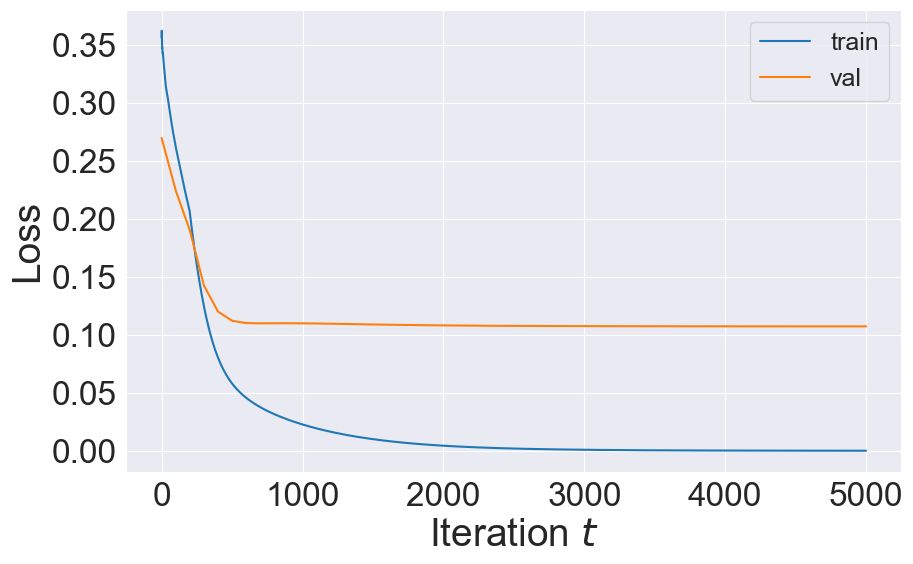

In [32]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val', 
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'losses-pop-conic-10-1.png'), bbox_inches='tight')
plt.show()

In [33]:
a.shape[1]

2010

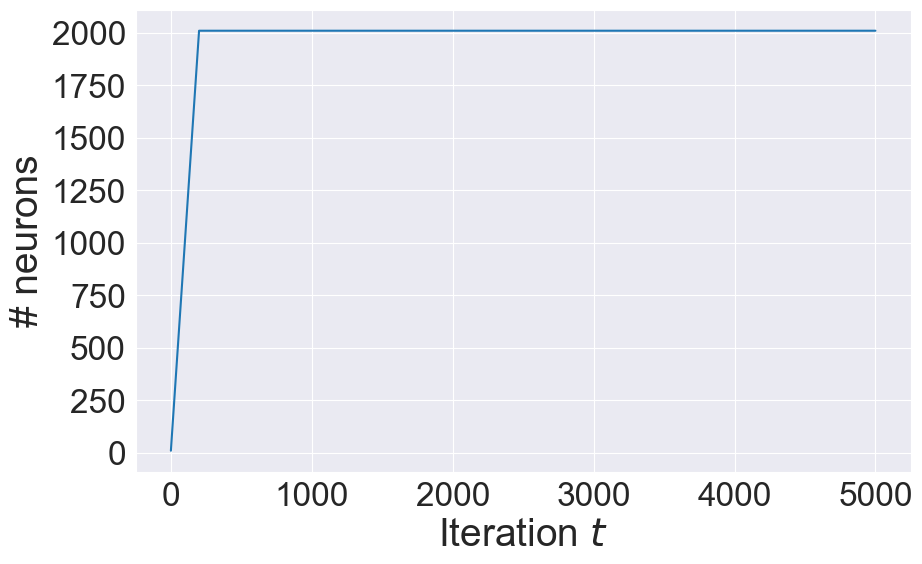

In [34]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(neurons)), neurons)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('# neurons', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'neurons-10-1.png'), bbox_inches='tight')
plt.show()

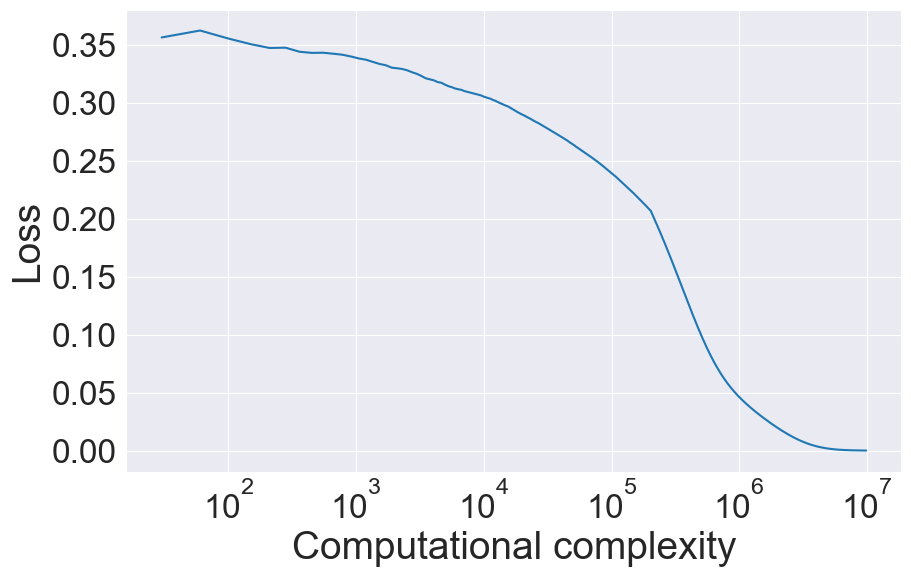

In [35]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses)

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-10-1.png'), bbox_inches='tight')
plt.show()

In [36]:
# FULL LOOP (POP-CONIC 10 sample & 10 update per step)
n_neurons = 10
n_updates = 10

a, b, _ = initialize_net(x_train, y_train, n_neurons=n_neurons)
a, b, train_losses, val_losses, neurons = train(N_STEPS//10, a, b, x_train, y_train, x_val, y_val, 
                                       n_samples=n_neurons, n_updates=n_updates)

  2%|▉                                        | 12/500 [00:00<00:04, 111.71it/s]

Train loss at step 0 : 0.31323
Validation loss at step 0 : 0.27067


 20%|████████▎                                | 102/500 [00:07<01:12,  5.47it/s]

Train loss at step 100 : 0.04230
Validation loss at step 100 : 0.10740


 40%|████████████████▍                        | 201/500 [00:47<03:16,  1.52it/s]

Train loss at step 200 : 0.01521
Validation loss at step 200 : 0.09880


 60%|████████████████████████▋                | 301/500 [01:42<01:48,  1.84it/s]

Train loss at step 300 : 0.00270
Validation loss at step 300 : 0.09974


 80%|████████████████████████████████▉        | 401/500 [02:39<00:59,  1.65it/s]

Train loss at step 400 : 0.00057
Validation loss at step 400 : 0.09944


100%|█████████████████████████████████████████| 500/500 [03:33<00:00,  2.35it/s]

Train loss at step 499 : 0.00014
Validation loss at step 499 : 0.09942


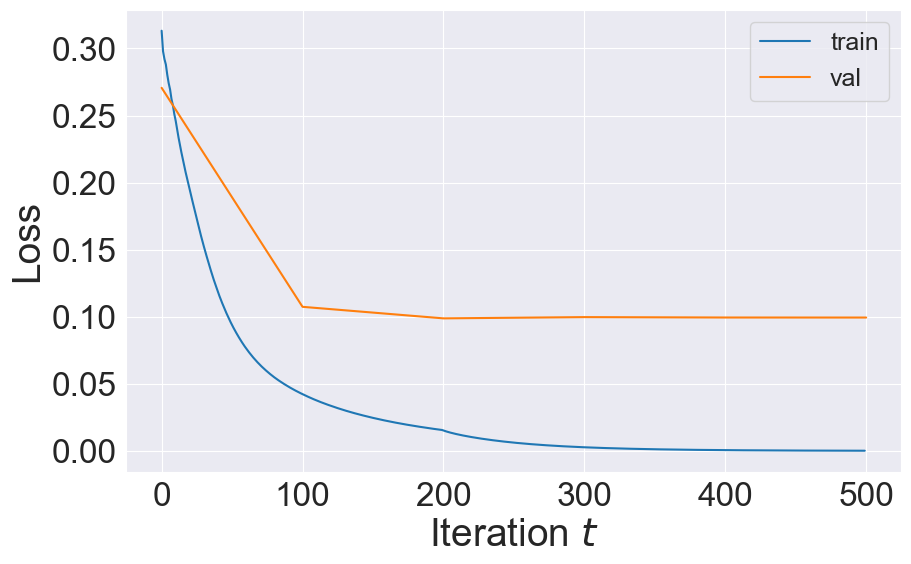

In [37]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val', 
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'losses-pop-conic-10-10.png'), bbox_inches='tight')
plt.show()

In [38]:
a.shape

(1, 2010)

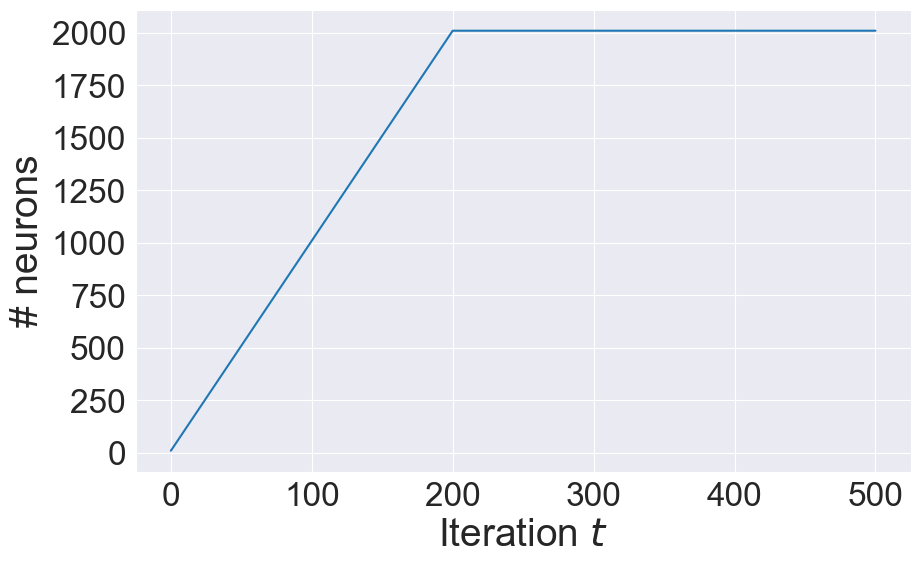

In [39]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(neurons)), neurons)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('# neurons', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'neurons-10-10.png'), bbox_inches='tight')
plt.show()

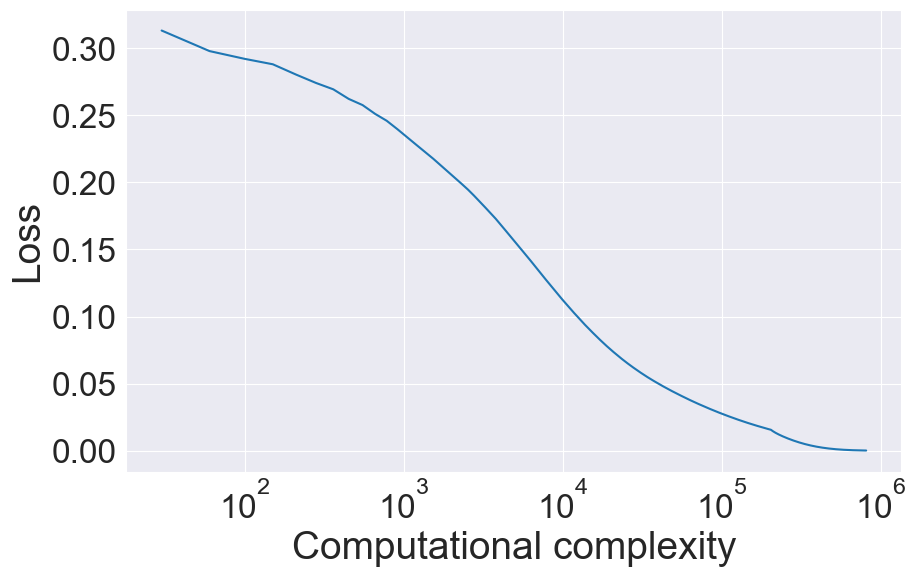

In [40]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses)

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-10-10.png'), bbox_inches='tight')
plt.show()